# Figure 5

In [1]:
using DifferentialEquations
using LabelledArrays
using Parameters
using Setfield
using MitochondrialDynamics
import MitochondrialDynamics: CaOsciSmooth
import MitochondrialDynamics.Utils: second, μM, mV, mM, Hz
# Plotting config
import PyPlot as plt
rcParams = plt.PyDict(plt.matplotlib."rcParams")
rcParams["font.size"] = 14
rcParams["font.sans-serif"] = "Arial"
rcParams["font.family"] = "sans-serif"

"sans-serif"

In [2]:
tend = 2000.0

u0 = LVector(g3p = 2.8μM,
             pyr = 8.5μM,
             nadh_c = 1μM,
             nadh_m = 60μM,
             atp_c = 4000μM,
             adp_c = 500μM,
             ca_m = 0.250μM,
             dpsi = 100mV,
             x2 = 0.2,
             x3 = 0.05)
param = setglc(MitoDynNode(), 10mM)
sssol = solve(SteadyStateProblem(model!, u0, param), DynamicSS(Rodas5(), tspan=tend))

u: 10-element LArray{Float64, 1, Vector{Float64}, (:g3p, :pyr, :nadh_c, :nadh_m, :atp_c, :adp_c, :ca_m, :dpsi, :x2, :x3)}:
    :g3p => 0.006004741445933519
    :pyr => 0.035196364354097814
 :nadh_c => 0.0031201505968590478
 :nadh_m => 0.10750877497620975
  :atp_c => 4.356898470231694
  :adp_c => 0.13897445622254367
   :ca_m => 0.0008438745128640482
   :dpsi => 0.12495108100184726
     :x2 => 0.2266267885254765
     :x3 => 0.04019616269827622

In [3]:
caavg = cacyto(sssol.u[:adp_c], sssol.u[:atp_c], param, nothing)

pOsc = @set param.cai = CaOsciSmooth(ka_ca=(caavg - 0.09μM) * 1.5)

sol = solve(ODEProblem(model!, sssol.u, tend, pOsc))

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 1931-element Vector{Float64}:
    0.0
    0.0005702505136582621
    0.0007555476303757932
    0.0009192362230792442
    0.0010827222854986882
    0.0012531898304953132
    0.0014319565043426966
    0.0016167615536932254
    0.0018038317822048535
    0.0019901507671573407
    0.002174468125523673
    0.002356983877061819
    0.0025385419366848218
    ⋮
 1985.2522605410977
 1986.3374756429716
 1987.474568495233
 1988.6697491016023
 1989.9302921734343
 1991.2648102725475
 1992.6836383738635
 1994.1993214019815
 1995.8270389574575
 1997.5856235066817
 1999.4986985211547
 2000.0
u: 1931-element Vector{LArray{Float64, 1, Vector{Float64}, (:g3p, :pyr, :nadh_c, :nadh_m, :atp_c, :adp_c, :ca_m, :dpsi, :x2, :x3)}}:
 10-element LArray{Float64, 1, Vector{Float64}, (:g3p, :pyr, :nadh_c, :nadh_m, :atp_c, :adp_c, :ca_m, :dpsi, :x2, :x3)}:
    :g3p => 0.0060047414459

In [4]:
# Same legend box for twin plots
# https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend

function plottwin!(ax, ts, ys, cac; title="", ylabel="", xlabel="Time (minute)", ylim=(), label="")
    ax.set_title(title, loc="left")
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    isempty(ylim) || ax.set_ylim(ylim...)
    lx = ax.plot(ts, ys, "k-")
    axca = ax.twinx()
    lca = axca.plot(ts, cac, "b--")
    axca.set_ylabel("Calcium (μM)")
    axca.set_ylim(0.0, 1.0)
    ax.legend([first(lx), first(lca)], [label, "Ca (c)"], loc="upper left")
    return ax
end

plottwin! (generic function with 1 method)

In [5]:
function plot_fig5(sol; ts = LinRange(1520, tend, 200), figsize=(10,12))

    g3p = sol.(ts, idxs=1)
    pyr = sol.(ts, idxs=2)
    nadh_c = sol.(ts, idxs=3)
    nadh_m = sol.(ts, idxs=4)
    atp_c = sol.(ts, idxs=5)
    adp_c = sol.(ts, idxs=6)
    # amp_c = ampcyto.(adp_c, atp_c, Ref(param))
    ca_m = sol.(ts, idxs=7)
    dpsi = sol.(ts, idxs=8)
    x2 = sol.(ts, idxs=9)
    x3 = sol.(ts, idxs=10)
    x1 = getx1.(x2, x3)
    ca_c = pOsc.cai.(ts)

    td = atp_c ./ adp_c
    avgDeg = avgdeg.(x2, x3, x1)
    
    # Convert mM to μM
    for arr in (g3p, pyr, nadh_c, nadh_m, ca_m, ca_c, atp_c, adp_c, dpsi)
        arr .*= 1000
    end

    # Convert sec to min
    tsm = ts ./ 60

    fig, ax = plt.subplots(6, 1, figsize=figsize)

    ax[1].plot(tsm, ca_c, label="Ca(c)")
    ax[1].plot(tsm, ca_m, label="Ca(m)")
    ax[1].set_title("A", loc="left")
    ax[1].set_ylabel("Conc. (μM)")
    # ax[1].set_xlabel("Time (minute)")
    ax[1].set_ylim(0.0, 1.0)
    ax[1].set_xlim(tsm[1], tsm[end])
    ax[1].legend(loc="right")

    ax[2].plot(tsm, g3p, label="G3P")
    ax[2].plot(tsm, nadh_c, label="NADH(c)")
    ax[2].set_title("B", loc="left")
    ax[2].set_ylabel("Conc. (μM)")
    # ax[2].set_ylim()
    ax[2].set_xlim(tsm[1], tsm[end])
    ax[2].legend(loc="right")


    ax[3].plot(tsm, pyr, label="Pyr")
    ax[3].plot(tsm, nadh_m, label="NADH(m)")
    ax[3].set_title("C", loc="left")
    ax[3].set_ylabel("Conc. (μM)")
    ax[3].set_xlim(tsm[1], tsm[end])
    ax[3].legend(loc="right")

    ax[4].plot(tsm, td, label="ATP:ADP")
    ax[4].set_title("D", loc="left")
    ax[4].set_ylabel("a.u.")
    ax[4].set_xlim(tsm[1], tsm[end])
    ax[4].legend(loc="right")

    ax[5].plot(tsm, dpsi, label="ΔΨ")
    ax[5].set_title("E", loc="left")
    ax[5].set_ylabel("mV")
    ax[5].set_xlim(tsm[1], tsm[end])
    ax[5].legend(loc="right")

    ax[6].plot(tsm, avgDeg, label="<k>")
    ax[6].set_title("F", loc="left")
    ax[6].set_ylabel("a.u.")
    ax[6].set_xlim(tsm[1], tsm[end])
    ax[6].legend(loc="right")
    ax[6].set_xlabel("Time (minute)")
    plt.tight_layout()

    fig
end

plot_fig5 (generic function with 1 method)

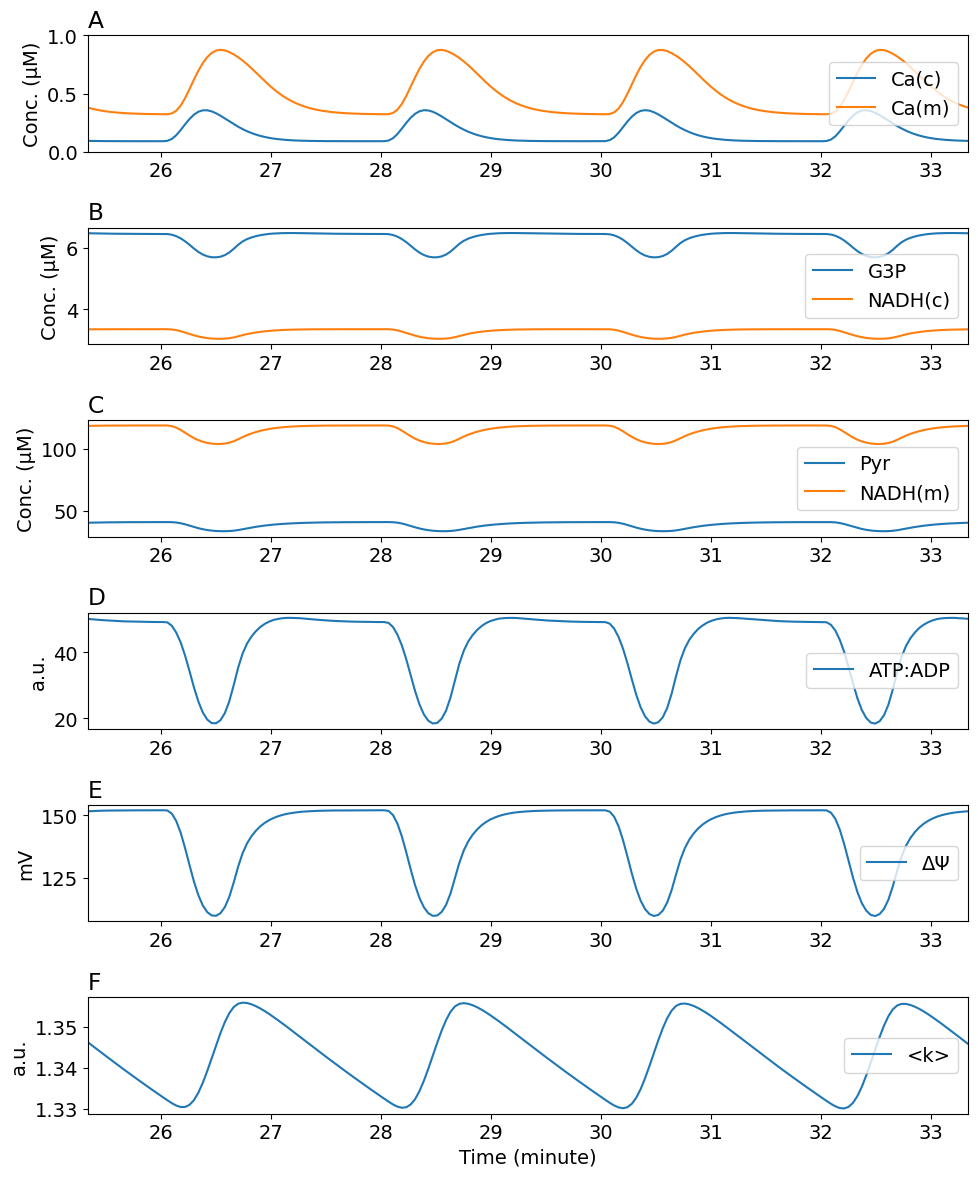

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /builds/NTUMito/wen-wei-tseng/MitochondrialDynamics/.julia/packages/PyCall/L0fLP/src/numpy.jl:67
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


In [6]:
fig5 = plot_fig5(sol);

In [7]:
# Uncomment to generate the pdf file 
# fig5.savefig("Fig5.pdf")